Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

# Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

1018
12


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
img_height = 180
img_width = 180
batch_size = 32

# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,                 # Path to the training dataset
    validation_split=0.2,           # Reserve 20% for validation
    subset="training",              # Indicating that this is the training subset
    seed=123,                       # Seed for reproducibility
    image_size=(img_height, img_width),  # Resizing images to the specified dimensions
    batch_size=batch_size           # Number of images per batch
)

Found 1018 files belonging to 9 classes.
Using 815 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,                 # Path to the training dataset (same as train because we are splitting)
    validation_split=0.2,           # Reserve 20% for validation
    subset="validation",            # Indicating that this is the validation subset
    seed=123,                       # Seed for reproducibility
    image_size=(img_height, img_width),  # Resizing images to the specified dimensions
    batch_size=batch_size           # Number of images per batch
)

Found 1018 files belonging to 9 classes.
Using 203 files for validation.


In [ ]:
# Get the class names from the training dataset
class_names = train_ds.class_names

# Print the class names
print("Classes of skin cancer:", class_names)

Classes of skin cancer: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

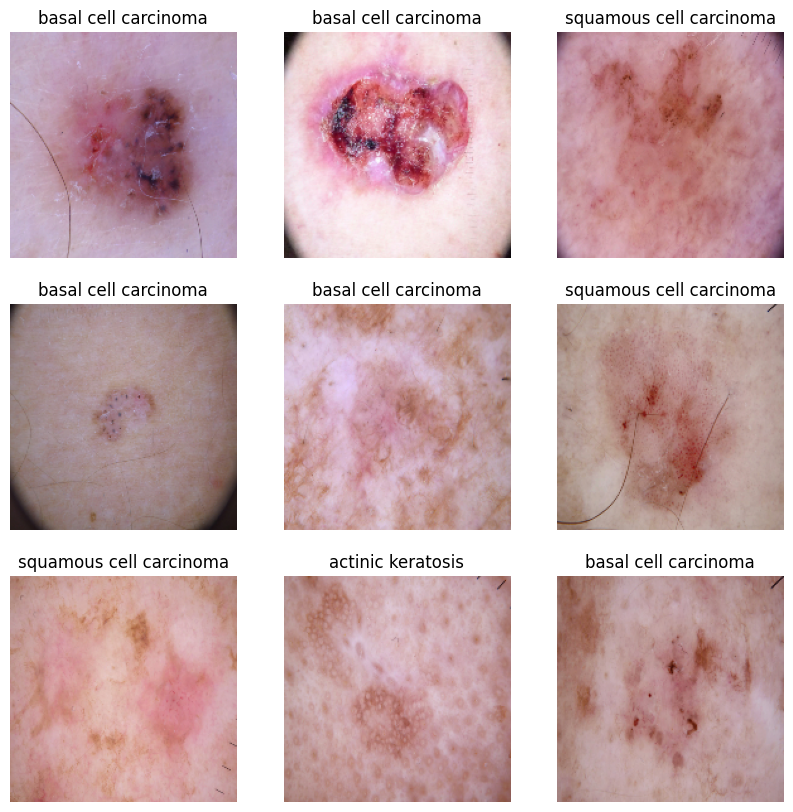

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch of images and labels
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])  # Display the class name as the title
        plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
from tensorflow.keras import layers, models

# Define the image input dimensions
input_shape = (img_height, img_width, 3)  # Height, width, and 3 color channels (RGB)

# Create the model
model = models.Sequential([
    # Input Rescaling layer
    layers.Rescaling(1./255, input_shape=input_shape),

    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the feature maps
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation='relu'),

    # Output layer with 9 units (for 9 classes) and softmax activation
    layers.Dense(len(class_names), activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 992ms/step - accuracy: 0.2530 - loss: 2.2531 - val_accuracy: 0.3941 - val_loss: 1.6858
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.3831 - loss: 1.6900 - val_accuracy: 0.4433 - val_loss: 1.5274
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4411 - loss: 1.5146 - val_accuracy: 0.4729 - val_loss: 1.3792
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4894 - loss: 1.3431 - val_accuracy: 0.4680 - val_loss: 1.3042
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5436 - loss: 1.2379 - val_accuracy: 0.5222 - val_loss: 1.3165
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5638 - loss: 1.2037 - val_accuracy: 0.5468 - val_loss: 1.1683
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6242 - loss: 1.0100 - val_accuracy: 0.5123 - val_loss: 1.3958
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6211 - loss: 0.9595 - val_accuracy: 0.5517 -

### Visualizing training results

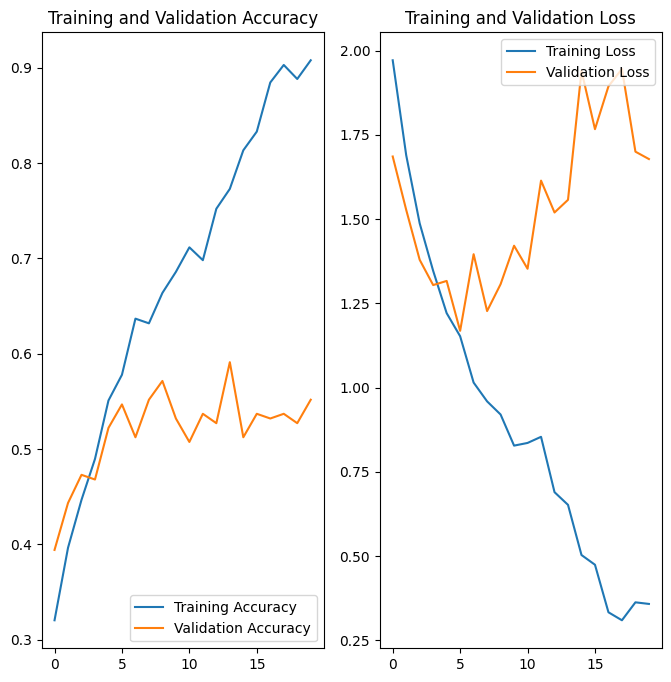

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

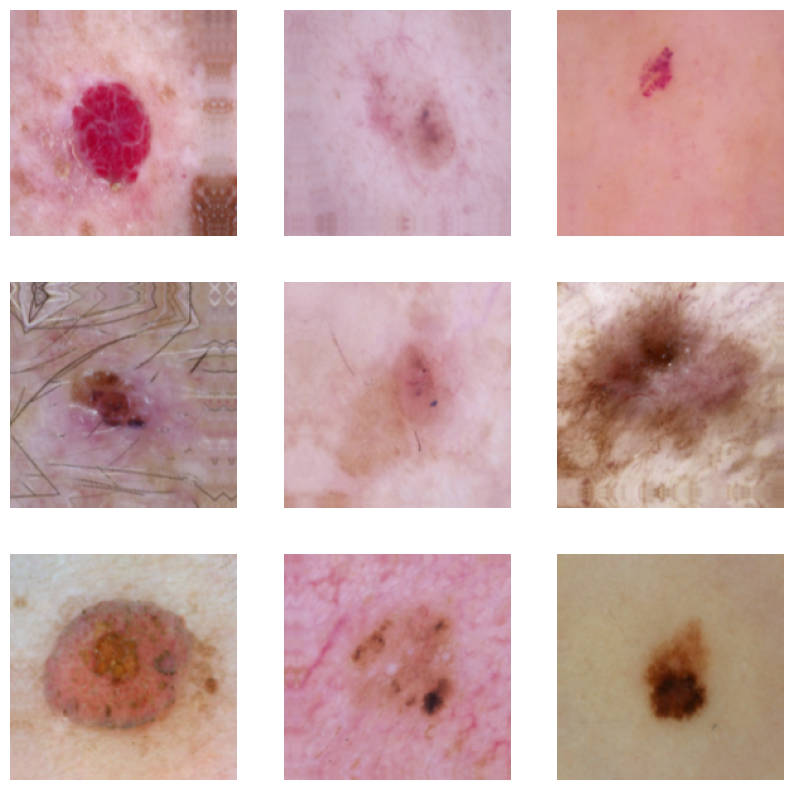

In [ ]:

# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    layers.RandomRotation(0.2),                    # Randomly rotate images
    layers.RandomZoom(0.1),                        # Randomly zoom images
    layers.RandomTranslation(0.1, 0.1)             # Randomly translate images
])

# Visualize augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):  # Take a batch from the training dataset
    augmented_images = data_augmentation(images)  # Apply augmentation
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")



### Todo:
### Create the model, compile and train the model


In [ ]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # Normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # Convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the 3D feature maps into a 1D vector
    layers.Flatten(),

    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])



### Compiling the model

In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,655,817 (25.39 MB)

 Trainable params: 6,655,817 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.2217 - loss: 2.3242 - val_accuracy: 0.3941 - val_loss: 1.9022
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3159 - loss: 1.9357 - val_accuracy: 0.3941 - val_loss: 1.8659
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3016 - loss: 1.8771 - val_accuracy: 0.3941 - val_loss: 1.9074
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3821 - loss: 1.8387 - val_accuracy: 0.4236 - val_loss: 1.8058
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3484 - loss: 1.8030 - val_accuracy: 0.4581 - val_loss: 1.6328
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3994 - loss: 1.7058 - val_accuracy: 0.4483 - val_loss: 1.4891
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4608 - loss: 1.5720 - val_accuracy: 0.4729 - val_loss: 1.4593
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4773 - loss: 1.5498 - val_accuracy: 0.4926 - 

### Visualizing the results

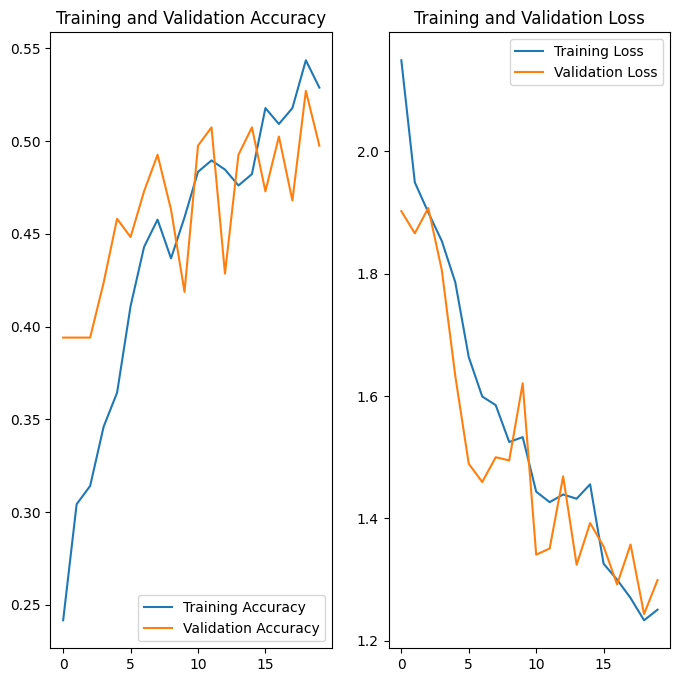

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
import os

# Path to the training dataset
path_to_training_dataset = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)

    if os.path.exists(class_path):
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)
    else:
        print(f"Directory {class_path} does not exist.")

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA44E565840>: 100%|██████████| 500/500 [00:27<00:00, 18.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3CABBC8E0>: 100%|██████████| 500/500 [00:18<00:00, 26.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA4307C16C0>: 100%|██████████| 500/500 [00:21<00:00, 23.29 Samples/s]


Initialised with 17 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2304x1536 at 0x7FA44E966F20>: 100%|██████████| 500/500 [03:20<00:00,  2.49 Samples/s]


Initialised with 19 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7FA3C1E6BDF0>: 100%|██████████| 500/500 [02:48<00:00,  2.96 Samples/s]


Initialised with 0 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

IndexError: There are no images in the pipeline. Add a directory using add_directory(), pointing it to a directory containing images.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000142.jpg_16dc57c6-585d-4f74-a576-f389b57b66f8.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000459.jpg_26eec554-b043-4449-bedf-3ba335f1b0e3.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000151.jpg_1b2b33e0-fbd5-4296-9579-ce9164b77373.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000149.jpg_c9f9f4a7-3fe9-445c-9e44-2cf047b6bf2c.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000526.jpg_a10e932c-a186-4799-bbf0-fc639014450f.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International

In [ ]:
path_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y)))
                   for y in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
new_df['Label'].value_counts()

,count
Label,
melanoma,1
nevus,1
basal cell carcinoma,1
actinic keratosis,1
dermatofibroma,1


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.